<a href="https://colab.research.google.com/github/cityu-assignment/CS3481-assignment2/blob/main/cs3481_asm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

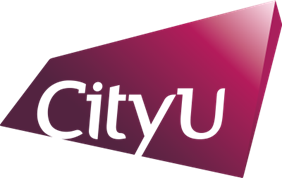

# **CS3481 Fundamentals of Data Science**

**Student Name: Lee Chak Kei**

**Student ID: 56682401**

# Import library

Importing necessary libraries then checks if the code is running in Google Colab and installs dtreeviz package silently, if it is.

In [34]:
import numpy as np 
import pandas as pd
import sklearn.tree as tree
import graphviz 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

import dtreeviz.trees

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from yellowbrick.model_selection.importances import FeatureImportances
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance

# Data Processing

The code loads a dataset file column_3C_weka.arff using arff.loadarff() function from scipy.io module, and creates a Pandas DataFrame from the data.

In [35]:
from scipy.io import arff

data = arff.loadarff("/content/column_3C_weka.arff")
df = pd.DataFrame(data[0])
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Hernia'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Hernia'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Hernia'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Hernia'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Hernia'
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,b'Normal'
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,b'Normal'
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,b'Normal'
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,b'Normal'


The code converts the data type of the 'class' column to string, and removes the first character ('b') of each element of the column (b'Hernia').

In [36]:
df['class'] = df['class'].astype('string')
df['class'] = [i[1:] for i in df['class']]
df['class']

0      'Hernia'
1      'Hernia'
2      'Hernia'
3      'Hernia'
4      'Hernia'
         ...   
305    'Normal'
306    'Normal'
307    'Normal'
308    'Normal'
309    'Normal'
Name: class, Length: 310, dtype: object

In [37]:
columns = df.iloc[:,:6].columns

The code selects the first 6 columns of the DataFrame as the feature matrix X.

In [38]:
X = df.iloc[:,:6].values
X[0:5]

array([[ 63.0278175 ,  22.55258597,  39.60911701,  40.47523153,
         98.67291675,  -0.25439999],
       [ 39.05695098,  10.06099147,  25.01537822,  28.99595951,
        114.4054254 ,   4.56425864],
       [ 68.83202098,  22.21848205,  50.09219357,  46.61353893,
        105.9851355 ,  -3.53031731],
       [ 69.29700807,  24.65287791,  44.31123813,  44.64413017,
        101.8684951 ,  11.21152344],
       [ 49.71285934,   9.65207488,  28.317406  ,  40.06078446,
        108.1687249 ,   7.91850062]])

Converts the categorical target variable 'class' to numerical using LabelEncoder() function from sklearn.preprocessing module. The transformed 'class' data is stored in y.

In [39]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['class'])
y = label_encoder.transform(df['class'])

# Global Variable

In [40]:
model_list = []

# Def Function

In [41]:
def constructRandomForestClassifiers(selected_Criterion):
  random_forest_iterator = [i for i in range(1, 80)]

  train_errors = []
  test_errors = [] 

  for i in random_forest_iterator:
      dtc = RandomForestClassifier(n_estimators = i,
                                   criterion=selected_Criterion,
                                   random_state=0
                                   )
      
      dtc.fit(X_trainset, y_trainset)
      
      trainAcc, testAcc, loss = printAcc(i, dtc)

      train_errors.append(trainAcc)
      test_errors.append(testAcc)
    
  plotTreeTrainTest(random_forest_iterator, train_errors, test_errors)

In [42]:
def compareModel():
  log_cols=["Classifier", "Accuracy", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for i in range(0, len(model_list)):
    clf = model_list[i]
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    trainAcc, testAcc, loss = printAcc(i, clf)

    predTree = clf.predict(X_testset)
    plotConfusionMatrix(predTree)
    
    log_entry = pd.DataFrame([[name, testAcc*100, loss]], columns=log_cols)
    log = log.append(log_entry)

  sns.set_color_codes("muted")
  sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

  plt.xlabel('Accuracy %')
  plt.title('Classifier Accuracy')
  plt.show()

  sns.set_color_codes("muted")
  sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

  plt.xlabel('Log Loss')
  plt.title('Classifier Log Loss')
  plt.show()

In [43]:
def printAcc(i, tree): 
  train_z = tree.predict(X_trainset)
  test_z = tree.predict(X_testset)

  train_acc = accuracy_score(y_trainset, train_z)
  test_acc = accuracy_score(y_testset, test_z)
  loss = log_loss(y_testset, tree.predict_proba(X_testset))

  print('>%d, train: %.3f, test: %.3f, loss: %.5f' % (i, train_acc, test_acc, loss))

  return train_acc, test_acc, loss

In [44]:
def plotTreeTrainTest(iterator, train_errors, test_errors):
  plt.plot(iterator, train_errors, '-o', label='Train') 
  plt.plot(iterator, test_errors, '-o', label='Test') 
  plt.ylabel('Accuracy')
  plt.xlabel('Maximum Depth')
  plt.legend() 
  plt.show() 

In [45]:
def plotFeatureImportance(clf):
  name = clf.__class__.__name__
  feat_importances = pd.Series(clf.feature_importances_, index = columns).sort_values(ascending = True)
  print(feat_importances)

  plt.ylabel('Features')
  plt.xlabel('Mean decrease in impurity')
  plt.title(name)

  feat_importances.plot(kind = 'barh')

In [46]:
def plotPermutationImportance(clf):
  name = clf.__class__.__name__
  perm_importance = permutation_importance(clf, X_testset, y_testset)
  sorted_idx = perm_importance.importances_mean.argsort()
  print(perm_importance)

  plt.ylabel('Features')
  plt.xlabel("Permutation Importance")
  plt.title(name)
  plt.barh(columns[sorted_idx], perm_importance.importances_mean[sorted_idx])

In [47]:
def plotConfusionMatrix(predTree):
  cm = confusion_matrix(y_testset, predTree)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_encoder.classes_))                        
  print(cm)
  disp.plot()

# Construct Random Forest Models

The function constructRandomForestClassifiers(selected_Criterion) is then defined to analyze multiple random forest model with test 0.3 splits. It uses the RandomForestClassifier function from sklearn.tree to construct a random forest model with a given criterion (entropy or gini) and random state. 

The constructRandomForestClassifiers function is called twice: once with selected_Criterion set to `entropy` and once with selected_Criterion set to `gini`.



In [48]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

`stratify=y` is used to ensure that the class distribution in the original dataset is maintained in both the training and testing sets. It is useful when dealing with imbalanced datasets where the target variable has unequal class distributions.

`random_state=0` is used to set a fixed seed for the random number generator. This ensures that each time the code is run with the same input data, the same random samples are selected for the training and testing sets. This is important for reproducibility of results, as different random splits can lead to different model performance.

## **Compare decision trees**


### **If criterion is entropy**



>1, train: 0.912, test: 0.796, loss: 7.36376
>2, train: 0.894, test: 0.742, loss: 2.93656
>3, train: 0.963, test: 0.849, loss: 1.80791
>4, train: 0.968, test: 0.828, loss: 1.44563
>5, train: 0.977, test: 0.806, loss: 1.10983
>6, train: 0.991, test: 0.817, loss: 1.07580
>7, train: 0.986, test: 0.806, loss: 1.07469
>8, train: 0.995, test: 0.849, loss: 0.70148
>9, train: 0.995, test: 0.860, loss: 0.69575
>10, train: 0.995, test: 0.839, loss: 0.69999
>11, train: 0.995, test: 0.849, loss: 0.70605
>12, train: 1.000, test: 0.849, loss: 0.69482
>13, train: 0.995, test: 0.849, loss: 0.68634
>14, train: 0.995, test: 0.860, loss: 0.67887
>15, train: 0.995, test: 0.839, loss: 0.68290
>16, train: 1.000, test: 0.828, loss: 0.68838
>17, train: 1.000, test: 0.839, loss: 0.68520
>18, train: 1.000, test: 0.828, loss: 0.33393
>19, train: 1.000, test: 0.828, loss: 0.34074
>20, train: 1.000, test: 0.828, loss: 0.33857
>21, train: 1.000, test: 0.860, loss: 0.33662
>22, train: 1.000, test: 0.828, loss: 0.334

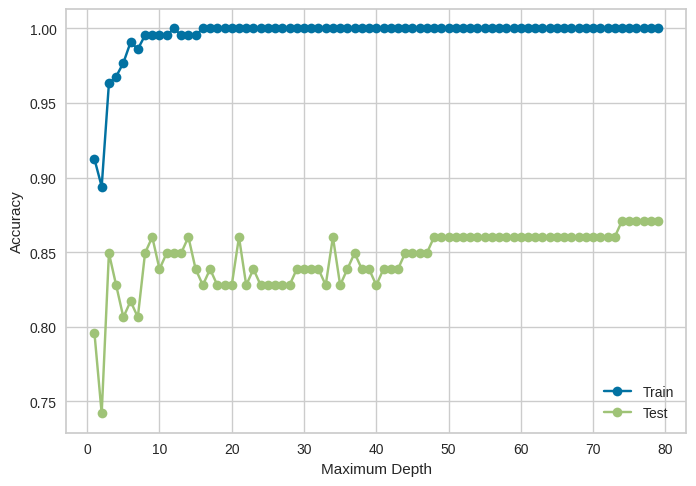

In [49]:
constructRandomForestClassifiers('entropy')


### **If criterion is gini**



>1, train: 0.917, test: 0.828, loss: 6.20106
>2, train: 0.912, test: 0.774, loss: 3.67443
>3, train: 0.968, test: 0.806, loss: 1.83955
>4, train: 0.977, test: 0.806, loss: 1.12823
>5, train: 0.991, test: 0.828, loss: 1.12252
>6, train: 0.986, test: 0.839, loss: 0.70985
>7, train: 0.986, test: 0.849, loss: 0.71266
>8, train: 0.986, test: 0.849, loss: 0.70762
>9, train: 0.986, test: 0.860, loss: 0.70884
>10, train: 0.995, test: 0.860, loss: 0.69305
>11, train: 0.986, test: 0.860, loss: 0.69023
>12, train: 0.995, test: 0.871, loss: 0.68520
>13, train: 0.991, test: 0.860, loss: 0.67897
>14, train: 0.995, test: 0.871, loss: 0.68047
>15, train: 0.995, test: 0.871, loss: 0.68683
>16, train: 1.000, test: 0.860, loss: 0.68963
>17, train: 1.000, test: 0.871, loss: 0.69005
>18, train: 1.000, test: 0.871, loss: 0.32952
>19, train: 1.000, test: 0.871, loss: 0.33273
>20, train: 1.000, test: 0.871, loss: 0.33210
>21, train: 1.000, test: 0.871, loss: 0.32831
>22, train: 1.000, test: 0.860, loss: 0.322

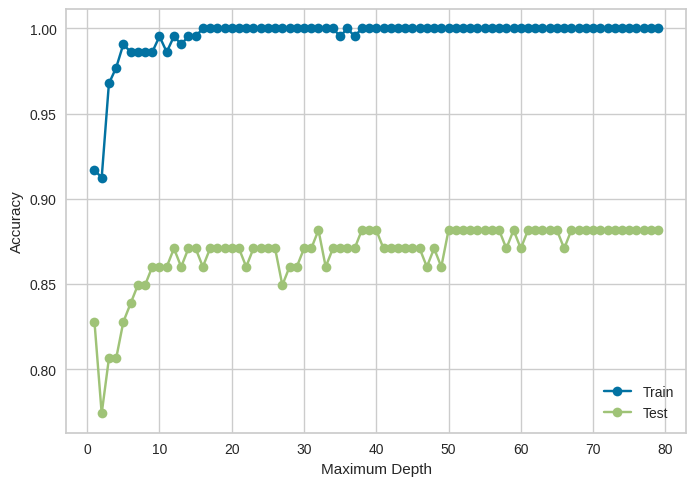

In [50]:
constructRandomForestClassifiers('gini')

Among all the decision trees, it seems that using gini, test size of 0.3 and a maximum tree depth of 7 obtains the best performance, with an accuracy of 0.86022 and without serious overfitting or underfitting. Although, using gini, test size of 0.3, and a maximum tree depth of 11 obtains the same accuracy 0.86022, it has serious overfitting problem. Therefore, we select gini, test size of 0.3 and a maximum tree depth of 7 decision tree.

If the maximum tree depth continues to increase, the overfitting problem will become more serious. Thus, we adopt an early stop approach to minimize the overfitting problem.

# Analysis selected Random Forest Model

### **Train the selected Random Forest Model**

Regarding the model performance, it seems decision tree using `gini`, test_size `0.3`, and max tree depth `7`, obtain the best accuracy and without overfitting or underfitting problem. Then defines `selected_test_size`, `selected_max_tree_depth`, and `selected_criterion` variables and uses them to train a single decision tree with a given criterion and maximum depth. It then uses the trained decision tree to predict the target variable for the testing data and computes the accuracy score.

In [51]:
n_estimators = 6
selected_criterion = 'gini'

In [52]:
clf = RandomForestClassifier(n_estimators = n_estimators,
                             criterion=selected_criterion,
                             random_state=0
                            )

clf.fit(X_trainset, y_trainset)

model_list.append(clf)

# Compare different component decision trees in the model

>0, train: 0.917, test: 0.828, loss: 6.20106
>1, train: 0.871, test: 0.710, loss: 10.46429
>2, train: 0.908, test: 0.742, loss: 9.30159
>3, train: 0.903, test: 0.688, loss: 11.23942
>4, train: 0.931, test: 0.753, loss: 8.91402
>5, train: 0.903, test: 0.839, loss: 5.81349


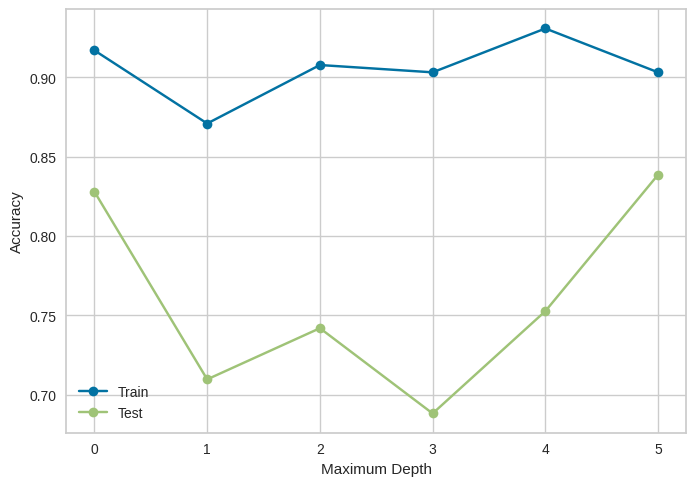

In [53]:
componentTree_iterator = [i for i in range(0, n_estimators)]

train_errors = []
test_errors = [] 

for i in componentTree_iterator:
  componentTree = clf.estimators_[i]

  trainAcc, testAcc, loss = printAcc(i, componentTree)

  train_errors.append(trainAcc)
  test_errors.append(testAcc)
    
plotTreeTrainTest(componentTree_iterator, train_errors, test_errors)

In [54]:
componentTree = clf.estimators_[5]

model_list.append(componentTree)

# Compare Random Forest Model and Component Tree

RandomForestClassifier
>0, train: 0.986, test: 0.839, loss: 0.70985
[[12  5  1]
 [ 4 25  1]
 [ 0  4 41]]
DecisionTreeClassifier
>1, train: 0.903, test: 0.839, loss: 5.81349
[[11  6  1]
 [ 5 24  1]
 [ 0  2 43]]


<ipython-input-42-8794ea5c468e>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<ipython-input-42-8794ea5c468e>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


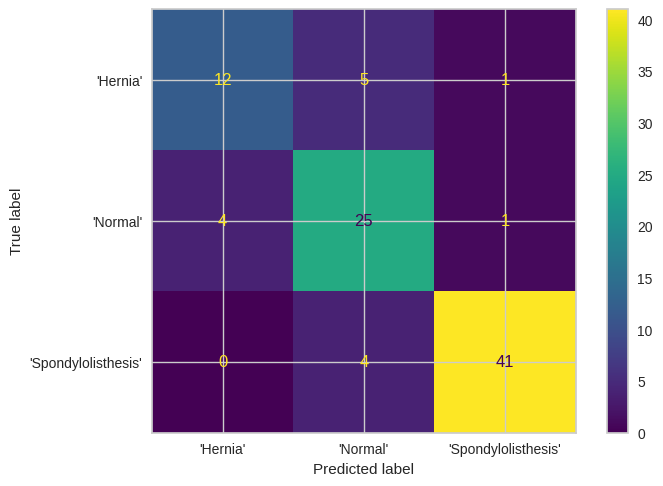

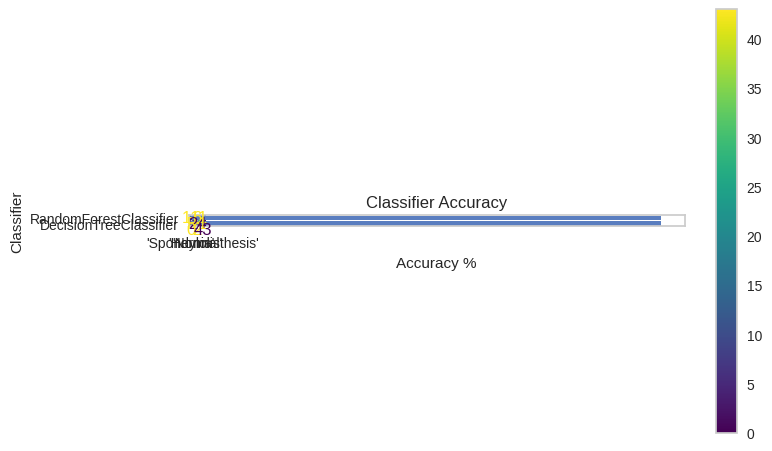

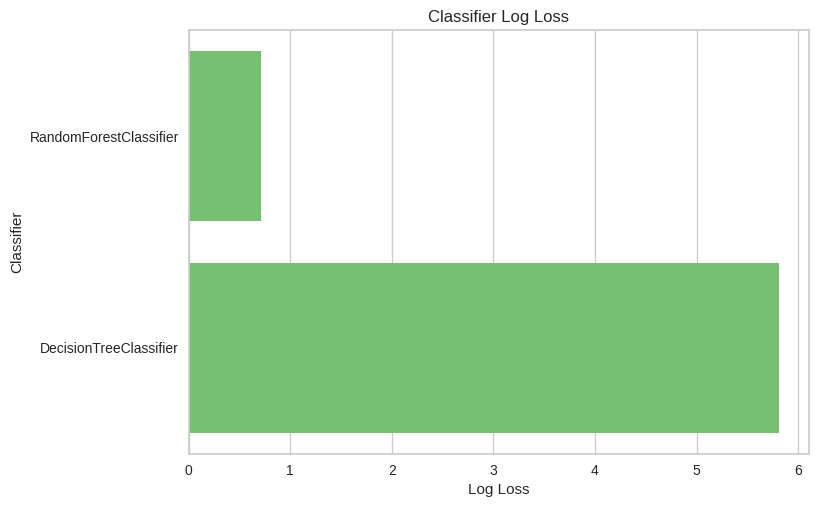

In [55]:
compareModel()

The model predicted 12 instances as class `Hernia`, and actually 12 of them were class `Hernia`.

The model predicted 5 instances as class `Hernia`, but they were actually class `Normal`.

The model predicted 1 instance as class `Hernia`, but it was actually class `Spondylolisthesis`.

The model predicted 5 instances as class `Normal`, but they were actually class `Hernia`.

The model predicted 23 instances as class `Normal`, and actually 23 of them were class `Normal`.

The model predicted 2 instances as class `Normal`, but they were actually class '`Spondylolisthesis`.

The model predicted 0 instances as class `Spondylolisthesis`, but they were actually class `Hernia`.

The model predicted 0 instances as class `Spondylolisthesis`, but they were actually class `Normal`.

The model predicted 45 instances as class `Spondylolisthesis`, and actually 45 of them were class `Spondylolisthesis`.

The confusion matrix shows that the model performed well on the third class, with no instances misclassified as class `Spondylolisthesis`. However, the model made some errors when classifying instances as class `Hernia` and class `Normal`. For example, 5 instances that were actually class `Hernia` were predicted as class `Normal`, and 2 instances that were actually class `Normal` were predicted as class `Spondylolisthesis`.

## Feature Importance

lumbar_lordosis_angle       0.105815
pelvic_radius               0.113105
pelvic_tilt                 0.119178
sacral_slope                0.147871
pelvic_incidence            0.175038
degree_spondylolisthesis    0.338992
dtype: float64


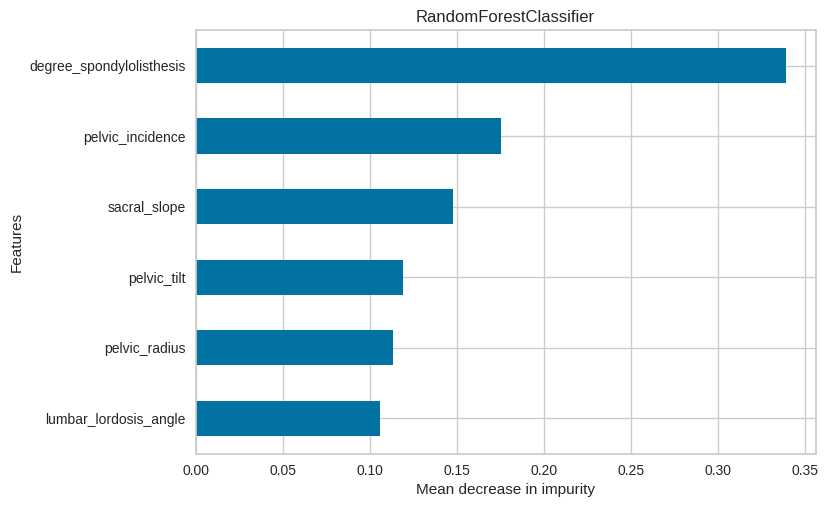

In [56]:
plotFeatureImportance(clf)

lumbar_lordosis_angle       0.033810
sacral_slope                0.089264
pelvic_tilt                 0.135226
pelvic_radius               0.240444
degree_spondylolisthesis    0.244202
pelvic_incidence            0.257055
dtype: float64


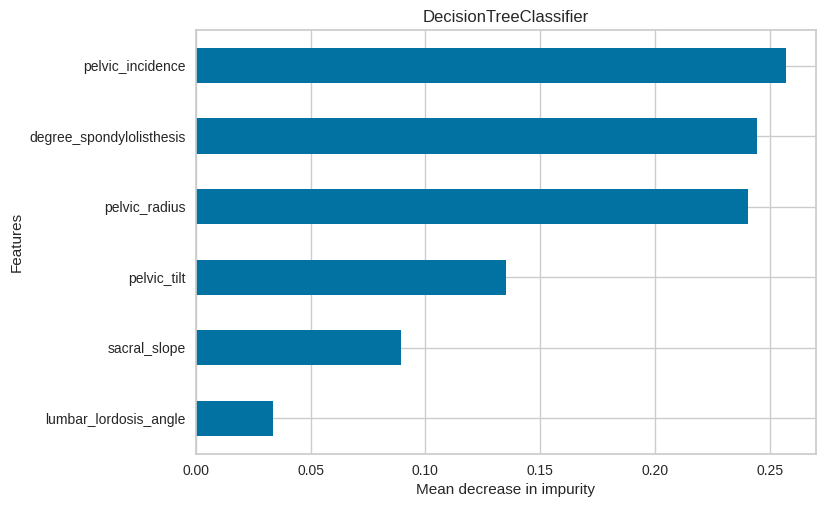

In [57]:
plotFeatureImportance(componentTree)

## Permutation Importance

{'importances_mean': array([0.03010753, 0.03655914, 0.00860215, 0.0516129 , 0.0516129 ,
       0.33548387]), 'importances_std': array([0.00430108, 0.00526772, 0.02296146, 0.02085024, 0.02085024,
       0.04158942]), 'importances': array([[ 0.03225806,  0.03225806,  0.03225806,  0.02150538,  0.03225806],
       [ 0.03225806,  0.04301075,  0.03225806,  0.04301075,  0.03225806],
       [ 0.03225806, -0.03225806,  0.        ,  0.02150538,  0.02150538],
       [ 0.04301075,  0.04301075,  0.02150538,  0.07526882,  0.07526882],
       [ 0.06451613,  0.06451613,  0.02150538,  0.07526882,  0.03225806],
       [ 0.37634409,  0.25806452,  0.34408602,  0.33333333,  0.3655914 ]])}


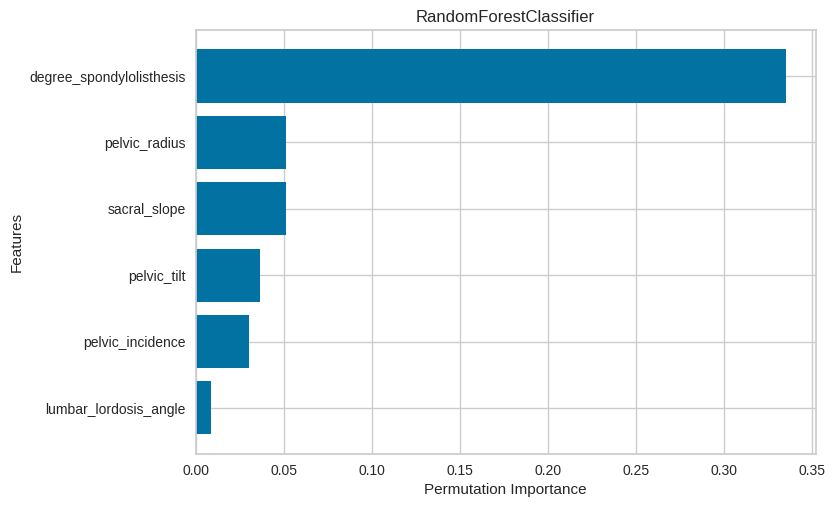

In [58]:
plotPermutationImportance(clf)

{'importances_mean': array([0.0688172 , 0.06666667, 0.03655914, 0.0172043 , 0.04301075,
       0.32043011]), 'importances_std': array([0.00860215, 0.02668747, 0.00526772, 0.01096563, 0.01799269,
       0.0172043 ]), 'importances': array([[0.07526882, 0.07526882, 0.05376344, 0.06451613, 0.07526882],
       [0.03225806, 0.08602151, 0.05376344, 0.05376344, 0.10752688],
       [0.04301075, 0.03225806, 0.04301075, 0.03225806, 0.03225806],
       [0.        , 0.03225806, 0.01075269, 0.02150538, 0.02150538],
       [0.02150538, 0.05376344, 0.05376344, 0.06451613, 0.02150538],
       [0.30107527, 0.30107527, 0.32258065, 0.33333333, 0.34408602]])}


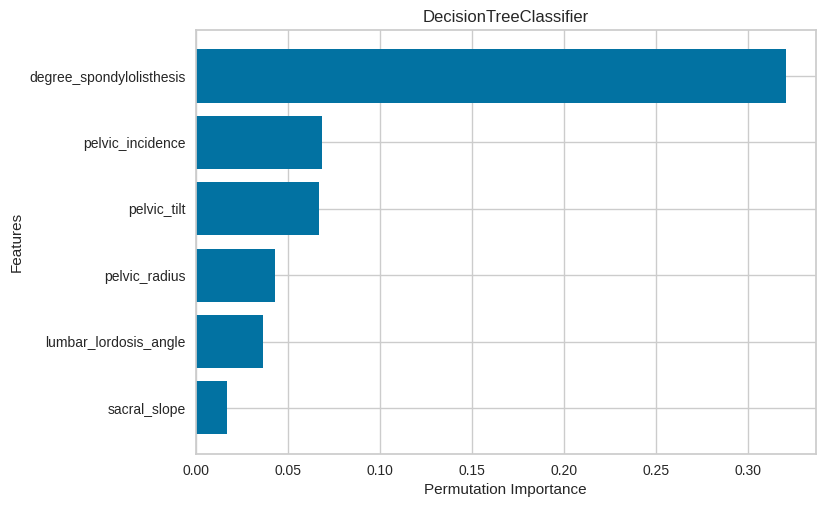

In [59]:
plotPermutationImportance(componentTree)

# Construct Naïve Bayes classifier model

In [60]:
nb = GaussianNB() 
nb.fit(X_trainset, y_trainset)
printAcc(0, nb)

model_list.append(nb)

>0, train: 0.829, test: 0.860, loss: 0.51885


# Compare All Model

RandomForestClassifier
>0, train: 0.986, test: 0.839, loss: 0.70985
[[12  5  1]
 [ 4 25  1]
 [ 0  4 41]]
DecisionTreeClassifier
>1, train: 0.903, test: 0.839, loss: 5.81349
[[11  6  1]
 [ 5 24  1]
 [ 0  2 43]]


<ipython-input-42-8794ea5c468e>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<ipython-input-42-8794ea5c468e>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


GaussianNB
>2, train: 0.829, test: 0.860, loss: 0.51885
[[13  4  1]
 [ 5 23  2]
 [ 0  1 44]]


<ipython-input-42-8794ea5c468e>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


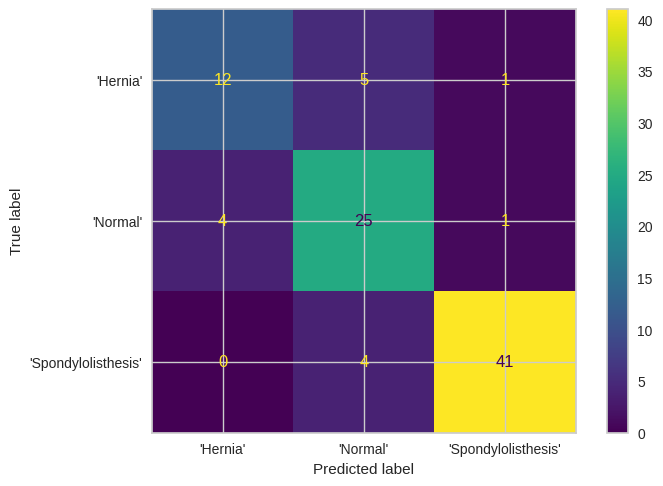

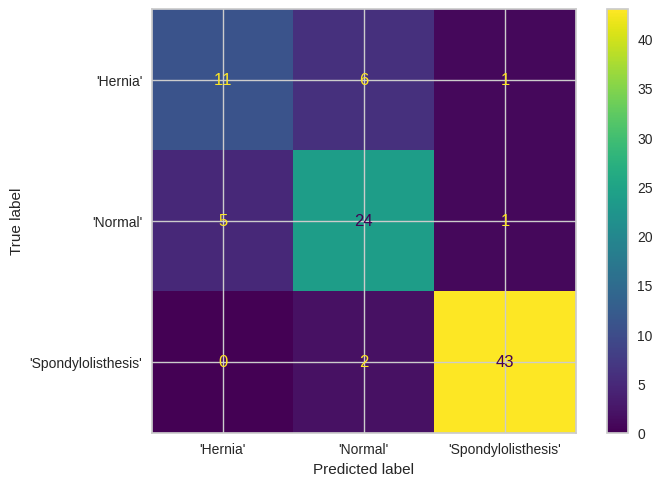

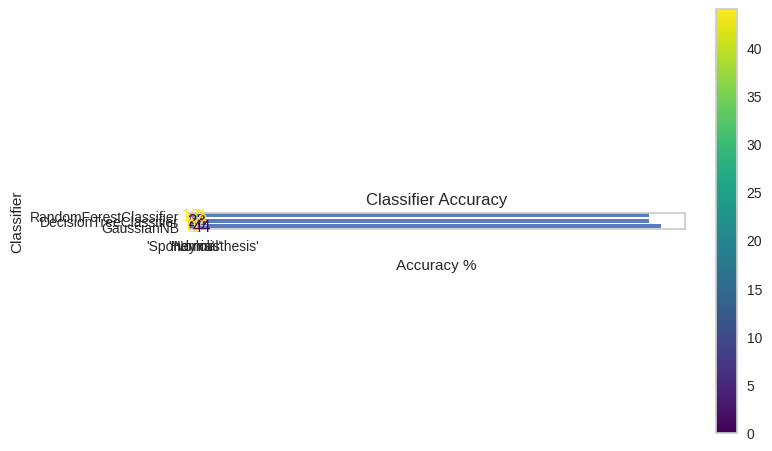

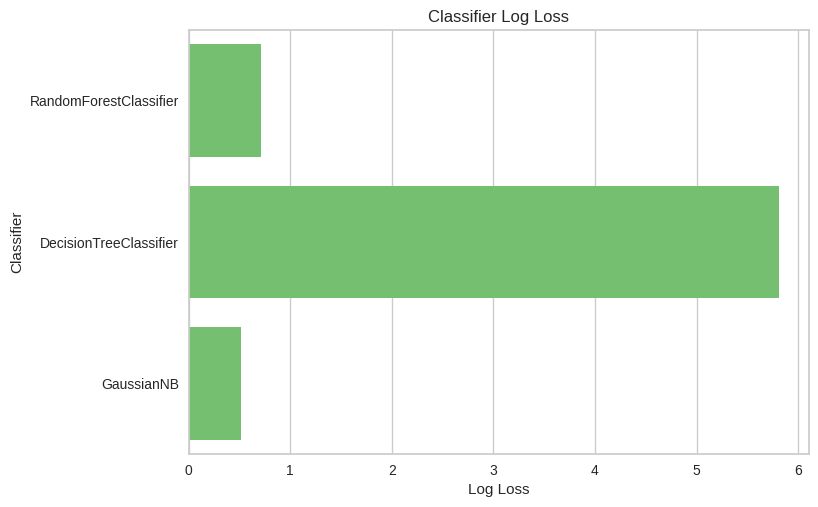

In [61]:
compareModel()